# Convert STRING PPI scores from table to matrix for each evidence channel

Information on STRING datasets at

- https://string-db.org/cgi/help.pl
- https://string-db.org/cgi/download.pl?species_text=Homo+sapiens

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
from IPython.display import display

from utils import get_string_dataset_path, get_protein_info_df

## Download and examine STRING datasets

In [2]:
# Show the head of protein info
gene_df = get_protein_info_df()
protein_to_index = gene_df.set_index('protein_external_id')['index'].to_dict()
gene_df.tail(2)

,index,protein_external_id,preferred_name,protein_size,annotation
19564,19564,9606.ENSP00000485675,ENSG00000280116,84,annotation not available
19565,19565,9606.ENSP00000485678,OR6Q1,317,Olfactory receptor 6Q1; Odorant receptor; Olfa...


In [3]:
# Show the head of protein links
link_path = get_string_dataset_path("protein.links.full")
link_head_df = pd.read_csv(link_path, sep=' ', nrows=2)
link_head_df

,protein1,protein2,neighborhood,neighborhood_transferred,fusion,cooccurence,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,0,332,0,0,62,0,181,0,0,0,125,490
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,0,0,0,0,186,0,0,0,56,198


## Convert protein links to matrix format

Each matrix contains a single evidence channel.

Construct matrices use dense numpy array for speed. Then convert to [`scipy.sparse.csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), so all matrices fit in memory.

In [4]:
def generate_link_df_itertuples():
    link_df_generator = pd.read_csv(link_path, sep=' ', chunksize=5_000)
    for link_df in link_df_generator:
        yield from link_df.itertuples()

def get_empty_score_array() -> np.ndarray:
    shape = len(gene_df), len(gene_df)
    score_array = np.zeros(shape, dtype=np.uint16)
    return score_array

def load_score_array(channel="combined_score") -> np.ndarray:
    array = get_empty_score_array()
    for row in generate_link_df_itertuples():
        index_1 = protein_to_index[row.protein1]
        index_2 = protein_to_index[row.protein2]
        array[index_1, index_2] = getattr(row, channel)
    return array

def array_to_df(array: np.ndarray):
    return pd.DataFrame(
        data=array,
        columns=gene_df.preferred_name,
        index=gene_df.preferred_name,
    )

In [5]:
channels = list(link_head_df.columns[2:])
len(channels)

14

In [6]:
%%time
score_arrays = {}
for channel in channels:
    print(channel)
    score_array = load_score_array(channel)
    score_array_sparse = scipy.sparse.csr_matrix(score_array)
    score_arrays[channel] = score_array_sparse

neighborhood
neighborhood_transferred
fusion
cooccurence
homology
coexpression
coexpression_transferred
experiments
experiments_transferred
database
database_transferred
textmining
textmining_transferred
combined_score
CPU times: user 26min 47s, sys: 11.6 s, total: 26min 59s
Wall time: 26min 59s


## Information on scores

In [7]:
def describe_array(channel: str, array: scipy.sparse.csr_matrix):
    info = {"channel": channel}
    info["nrows"], info["ncols"] = array.shape
    info["size"] = np.prod(array.shape)
    info["n_nonzero"] = array.nnz
    info["density"] = "{:.3%}".format(info["n_nonzero"] / info["size"])
    info["n_non_symmetric"] = (array - array.transpose()).nnz
    if info["n_nonzero"] > 0:
        info["nonzero_mean"] = array.data.mean()
        info["nonzero_median"] = np.median(array.data)
    return info

In [8]:
rows = (describe_array(*args) for args in score_arrays.items())
channel_info_df = pd.DataFrame(rows)
channel_info_df

,name,nrows,ncols,size,n_nonzero,density,n_non_symmetric,nonzero_mean,nonzero_median
0,neighborhood,19566,19566,382828356,0,0.000%,0,NaN,NaN
1,neighborhood_transferred,19566,19566,382828356,404222,0.106%,0,93.567302,70.0
2,fusion,19566,19566,382828356,23388,0.006%,0,82.749102,6.0
3,cooccurence,19566,19566,382828356,60404,0.016%,0,346.419409,361.0
4,homology,19566,19566,382828356,217710,0.057%,0,676.650379,631.0
5,coexpression,19566,19566,382828356,2513002,0.656%,0,131.588230,98.0
6,coexpression_transferred,19566,19566,382828356,5090144,1.330%,0,89.584010,62.0
7,experiments,19566,19566,382828356,445816,0.116%,0,341.087009,305.0
8,experiments_transferred,19566,19566,382828356,4296274,1.122%,0,158.216116,157.0
9,database,19566,19566,382828356,706440,0.185%,0,859.364192,900.0


## Score distributions

Plot nonzero scores for each evidence channel.

In [9]:
def plot_score_distribution(array: scipy.sparse.csr_matrix, channel: str=""):
    plt.figure(figsize=(8, 2))
    plt.hist(array.data, bins = np.arange(0, 1001, 10)) 
    plt.title(f"score histogram: {channel}") 
    plt.show()

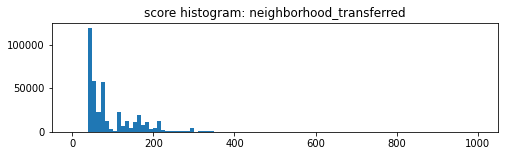

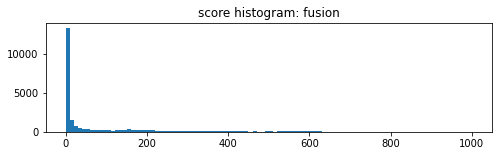

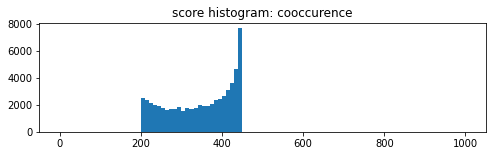

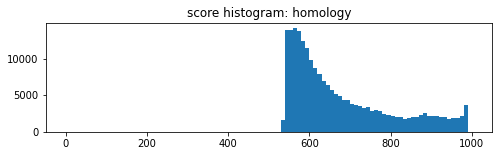

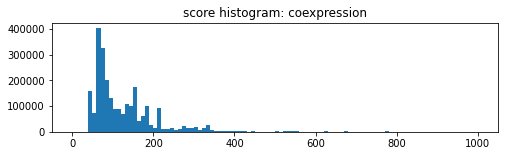

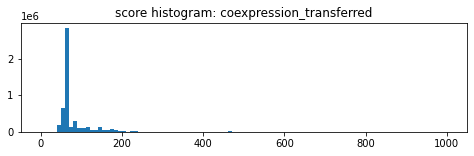

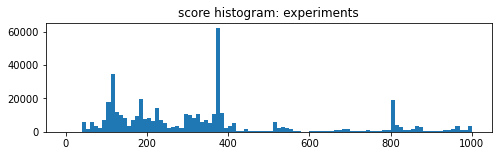

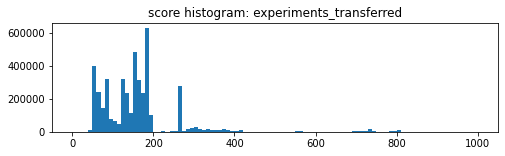

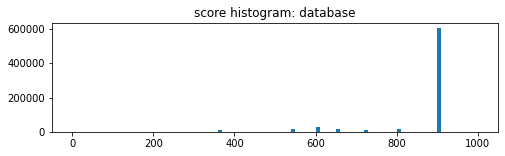

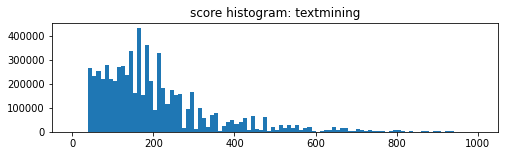

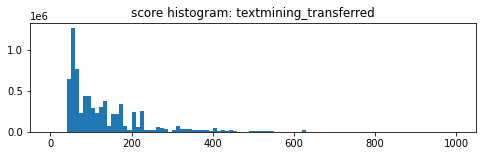

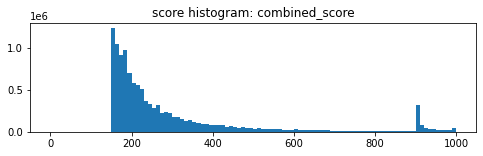

In [10]:
for channel, array_sparse in score_arrays.items():
    if array_sparse.nnz == 0:
        # skip plotting distributions with no nonzero values
        continue
    plot_score_distribution(array_sparse, channel)

## Write to disk

Save sparse matrices to disk using [compressed npz format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.save_npz.html), which is space efficifient, but whose reading is limited to `scipy.sparse.load_npz`.

Also save the scores to a XZ-compressed CSV file, which is less efficient but more interoperable and widely supported. gz compression is more widely supported but has worse compression ratios and included a timestamp header making for non-deterministic file hashes.

In [11]:
# ensure preferred_name never contains commas (to play nice with CSV)
assert not gene_df.preferred_name.str.contains(",").any()

In [14]:
def array_to_df(array: np.ndarray):
    return pd.DataFrame(
        data=array,
        columns=gene_df.preferred_name,
        index=gene_df.preferred_name,
    )

In [19]:
%%time
for channel, array_sparse in score_arrays.items():
    if array_sparse.nnz == 0:
        continue
    # save as .sparse.npz
    path = f"data/score-matrices/{channel}.sparse.npz"
    scipy.sparse.save_npz(path, array_sparse, compressed=True)
    # save as .csv.xz
    path = f"data/score-matrices/{channel}.csv.xz"
    matrix_df = array_to_df(array_sparse.todense())
    matrix_df.to_csv(path, index=False)

CPU times: user 51min 25s, sys: 5.46 s, total: 51min 30s
Wall time: 51min 31s


In [20]:
# Show what matrix_df looks like
print(channel)
matrix_df.iloc[:3, :5]

combined_score


preferred_name,ARF5,M6PR,FKBP4,CYP26B1,NDUFAF7
preferred_name,,,,,
ARF5,0,161,0,0,0
M6PR,161,0,0,0,0
FKBP4,0,0,0,0,0
